# Reading the data

In [9]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataPath = "../data/"

In [ ]:
# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [ ]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

In [ ]:
print receptor_names

# Training classifiers and printing results

In [3]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKF
import sklearn

In [4]:
def getB(n):
    if n == 0:
        return(None)
    if n == 1:
        return([[0], [1]])
    else:
        res0 = getB(n - 1)
        res = list()
        for a in res0:
            res.append([0] + a)
        for a in res0:
            res.append([1] + a)
        return(res)
def plotROCCurve(fpr, tpr, text, filename):
    """
     Plot a ROC curve from fpr, tpr
    """

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
       'font.size' : 15,
#          'font.family' : 'lmodern',
       'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.tick_params(axis='both', which='major')
    plt.title(str(text), fontsize=15)
    if filename != None:
        plt.savefig(filename + ".eps", bbox_inches = 'tight')
    plt.show()
def getShowROC(classifier, Xc, Yc):
        Ys = classifier.decision_function(Xc)
        fpr, tpr, _ = roc_curve(Yc, Ys)
        plotROCCurve(fpr, tpr, "ROC", None)
def getXY(classToTrain, X, Y, badValue = 999):
    """
    Get objects and answers for class classToTrain
    for which answers are available
    """
    
    haveAnswersObjectsIndices = np.where(Y[:, classToTrain] != badValue)
    classX = X[haveAnswersObjectsIndices, :][0]
    classY = Y[haveAnswersObjectsIndices, classToTrain][0]
    return classX, classY

In [198]:
class PCC:
    Xc = None
    Yc = None
    C = None
    X = None
    Y = None
    badValue = None
    m = 0
    def __init__(self):
        return None
    def initialize(self, m, X, Y, badValue):
        self.X = np.copy(X)
        self.Y = np.copy(Y)
        self.Xc = [None] * m
        self.Yc = [None] * m
        self.badValue = badValue
        self.m = m
        self.C = [None] * m
    #def fit(self, X, Y, badValue = 999):
    #    for i in range(Y.shape[1]):
    #        fitOne(self, X, Y, badValue, i)
    def fitOne(self, i):
        self.C[i] = None
        ind = np.where(self.Y[:, i] != self.badValue)
        X0 = self.X[ind]
        Yc = self.Y[ind][:, i]
        Y1 = np.copy(self.Y[ind][:, 0:i])
        
        #print Yc.shape
        #print Y1.shape
        
        #for k in range(Y1.shape[0]):
        #    for j in range(Y1.shape[1]):
        #        if Y1[k, j] == self.badValue:
        #            #print k, j
        #            Y1[k, j] = self.predict(X0[k], j)
        
        if Y1.shape[1] > 0:
            #print X[ind].shape
            #print Y1.shape
            Xc = np.concatenate((self.X[ind], Y1), axis=1)
        else:
            Xc = self.X[ind]
        
        self.Xc[i] = Xc
        self.Yc[i] = Yc
        
        #class_weight = 'balanced'
        tmpLR = LR(fit_intercept = False, solver='liblinear', n_jobs=3)
        tmpLR.fit(Xc, Yc)
        self.C[i] = tmpLR
        self.showFPRTPR(i)
    def adjustOne(self, i, fprThresold = 0.2):
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        #getShowROC(self.C[i], Xc, Yc)
        objInd = self.getIndexByFPR(i, fprThresold)
        self.setClassifierObject(i, objInd)
        self.showFPRTPR(i)
    def updatePredictions(self, j):
        for i in range(self.X.shape[0]):
            if self.Y[i][j] == self.badValue:
                self.Y[i][j] = self.predict(X[i], j)
    def showFPRTPR(self, i):
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        classifier = self.C[i]
        N = len(np.where(Yc == 0)[0])
        P = len(np.where(Yc == 1)[0])
        TP = len(np.where((classifier.predict(Xc) == 1) & (Yc == 1))[0])
        FP = len(np.where((classifier.predict(Xc) == 1) & (Yc == 0))[0])
       # print("Got FPR=%.1f %% TPR=%.1f %%" % (100. * FP / N, 100. * TP / P))
    def getIndexByFPR(self, i, fprLow):
        classifier = self.C[i]
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        YScore = classifier.decision_function(Xc)
        Ys = np.argsort(YScore)[::-1]
        N = len(np.where(Yc==0)[0])
        P = len(np.where(Yc==1)[0])
        fpr0 = 0
        tpr0 = 0
        res = None
        for i in range(Ys.shape[0]):
            ansr = Yc[Ys[i]]
            if ansr == 0:
                fpr0 += 1
            if ansr == 1:
                tpr0 += 1
                
            if 1. * fpr0 / N >= fprLow and res == None:
                return(Ys[i])
    def setClassifierObject(self, i, index):
        classifier = self.C[i]
        Xc = self.Xc[i]
        classifier.intercept_ = 0
        classifier.intercept_ = -classifier.decision_function([Xc[index]])
    def probabilityItem(self, x, y):
        res = 1
        for i in range(len(y)):
            x1 = list(x) + y[0:i]
            if self.C[i] != None:
                res *= self.C[i].predict_proba([x1])[0][y[i]]
        return(res)
    def probabilityClassRecursive(self, x, ic, il = 0):
        if ic == il:
            if self.C[ic] == None:
                return 0
            else:
                return self.C[ic].predict_proba([x])[0][1]
        else:
            fl = self.C[il].predict_proba([x])[0][1]
            return(fl * self.probabilityClassRecursive(list(x) + [1], ic, il + 1) + 
                  (1 - fl) * self.probabilityClassRecursive(list(x) + [0], ic, il + 1))
    def probabilityClasses(self, x):
        res = np.zeros(self.m)
        i = 0
        while i < self.m:
            if self.C[i] != None:
                res[i] = self.probabilityClassRecursive(x, i)
            i += 1
        return(res)
#    def probabilityClassesSlow(self, x):
#        m0 = 0
#        while m0 < self.m:
#            if self.C[m0] == None:
#                break
#            m0 += 1
#        Bm0 = getB(m0)
#        res = np.zeros(self.m)
#        for v in Bm0:
#            for j in range(m0):
#                if v[j] == 1:
#                    res[j] += probabilityItem(self, x, v)
#        return(res)
    def probabilityClassesSubset(self, x):
        m0 = 0
        while m0 < self.m:
            if self.C[m0] == None:
                break
            m0 += 1
        Bm0 = getB(m0)
        res = None
        maxP = 0
        for v in Bm0:
            p = self.probabilityItem(x, v)
            if p > maxP:
                res = v
                maxP = p
        res = res + [0] * (self.m - m0)
        return(res)
    def predictRankLoss(self, x, i):
        return(self.probabilityClassRecursive(x, i) >= 0.5)
    def probabilityNew(self, x, v, i):
        #v1 = v
        #v1[i] = 0
        #p0 = self.probabilityItem(x, v1)
        #v1[i] = 1
        #p1 = self.probabilityItem(x, v1)
        #return(p1 / (p0 + p1))
        #res = self.probabilityItem(x,v)
        #if v[i] == 0:
        #    res = 1 - res
        #return(res)
        #v1 = v[0:i]+[1]
        #return(self.probabilityItem(x,v1))
        #x1 = list(x)
        #for j in range(i + 1):
        #    if self.C[j] != None:
        #        val = self.C[j].predict_proba([x1])[0][1]
        #        ans = [val]
        #        x1 = x1 + ans
        x1 = list(x) + v[0:i]
        val = self.C[i].predict_proba([x1])[0][1]
        return(val)
    def probabilityClassesNew(self, x):
        res = np.zeros(self.m)
        i = 0
        v = self.probabilityClassesSubset(x)
        while i < self.m:
            if self.C[i] != None:
                res[i] = self.probabilityNew(x, v, i)
            i += 1
        return(res)

In [77]:
a = PCC()
a.initialize(Y.shape[1], X, Y, 999)
for i in range(10):
    %time a.fitOne(i)
    %time a.adjustOne(i, 0.2)
    %time a.updatePredictions(i)

NameError: name 'Y' is not defined

In [78]:
folds = 5
IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                               random_state=32)
#IFolds = SKF(Y, folds)
maxC = 10

roc_auc = np.zeros((folds, maxC))
fold = 0
for ITrain, ITest in IFolds:
    # get train & test data
    XTrain, YTrain = X[ITrain], Y[ITrain]
    XTest,  YTest  = X[ITest],  Y[ITest]

    Ys = np.zeros(YTest.shape)
    
    algo = PCC()
    algo.initialize(YTrain.shape[1], XTrain, YTrain, 999)
    for i in range(maxC):
        print("fit %d" % i)
        algo.fitOne(i)
        print("adjust %d" % i)
        algo.adjustOne(i, 0.2)
        print("updatePredictions %d" % i)
        algo.updatePredictions(i)
    
    print("calculating ROC...")
    
    for j in range(XTest.shape[0]):
        Ys[j] = algo.probabilityClasses(XTest[j])
    
    for i in range(maxC):
        ind = np.where(YTest[:, i] != 999)
        X1 = XTest[ind]
        Y1 = YTest[ind, i][0]
        Ys0 = Ys[ind, i][0]

        fpr, tpr, _ = roc_curve(Y1, Ys0)
        plotROCCurve(fpr, tpr, "Fold %d Class %d ROC" % (fold + 1, i + 1), None)
        roc_auc[fold][i] = auc(fpr, tpr)
    fold += 1
       
for i in range(maxC):
    auc_mean = np.mean(roc_auc[:, i])
    auc_std = np.std(roc_auc[:, i])
    print("Class %d AUC %.2g +- %.1g" % (i + 1, auc_mean, auc_std))

NameError: name 'X' is not defined

# Model data

In [6]:
def Sigma(x):
    return(1. / (1 + np.exp(-x)))


In [192]:
def showROCCurve(fpr, tpr, auc_mean, auc_std, filename):
    """
    Plot a ROC curve from fpr, tpr
    """
    
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
          'font.size' : 15,
#          'font.family' : 'lmodern',
          'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.tick_params(axis='both', which='major')
    auc_mean = '%.2g' % auc_mean
    auc_std = '%.1g' % auc_std
    plt.title(r"AUC $= %s\,\pm\,%s$" % (auc_mean, auc_std), fontsize=15)
    plt.savefig(filename + ".eps", bbox_inches = 'tight')
    plt.show()
def BRShow(X, Y, folds):
    IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                                   random_state=32)
    #IFolds = SKF(Y, folds)
    maxC = 3

    roc_auc = np.zeros((folds, maxC))
    subsetLossArr = np.zeros(folds)
    fold = 0
    for ITrain, ITest in IFolds:
        # get train & test data
        XTrain, YTrain = X[ITrain], Y[ITrain]
        XTest,  YTest  = X[ITest],  Y[ITest]

        subsetLossTemp = np.zeros(YTest.shape)
        
        for i in range(maxC):
            classifier = LR(class_weight = 'balanced')
            classifier.fit(XTrain, YTrain[:,i])

            # get predicted probabilities for class
            YScore = classifier.predict_proba(XTest)[:, 1]
            
            subsetLossTemp[:, i] = (classifier.predict(XTest) == YTest[:, i])

            # calculate fpr and tpr
            fpr, tpr, _ = roc_curve(YTest[:,i], YScore)
            
            #plotROCCurve(fpr, tpr, "Fold %d Class %d ROC" % (fold + 1, i + 1), None)
            roc_auc[fold][i] = auc(fpr, tpr)
        subsetLossArr[fold] = 1. * len(np.where(np.all(subsetLossTemp, axis = 1)==0)[0]) / XTest.shape[0]
        fold += 1

    for i in range(maxC):
        auc_mean = np.mean(roc_auc[:, i])
        auc_std = np.std(roc_auc[:, i])
        print("Class %d AUC %.2g +- %.1g" % (i + 1, auc_mean, auc_std))
    subset_mean = np.mean(subsetLossArr)
    subset_std = np.std(subsetLossArr)
    print("SUBSET %.5f %.1f" % (subset_mean, subset_std))
def PCCShow(X, Y, folds, thr = 0.2, do_new = False):
    IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                                   random_state=32)
    #IFolds = SKF(Y, folds)
    maxC = 3

    roc_auc = np.zeros((folds, maxC))
    fold = 0
    subsetLossArr = np.zeros(folds)
    for ITrain, ITest in IFolds:
        # get train & test data
        XTrain, YTrain = X[ITrain], Y[ITrain]
        XTest,  YTest  = X[ITest],  Y[ITest]

        Ys = np.zeros(YTest.shape)

        algo = PCC()
        algo.initialize(YTrain.shape[1], XTrain, YTrain, 999)
        for i in range(maxC):
           # print("fit %d" % i)
            algo.fitOne(i)
          #  print("adjust %d" % i)
           # algo.adjustOne(i, thr)

    #    print("calculating ROC...")

        subsetLoss = 0
        for j in range(XTest.shape[0]):
            if do_new:
                Ys[j] = algo.probabilityClassesNew(XTest[j])
            else:
                Ys[j] = algo.probabilityClasses(XTest[j])
            ans1 = algo.probabilityClassesSubset(XTest[j])
            ans2 = YTest[j]
            if np.any(ans1 != ans2):
                subsetLoss += 1
               # print("Got error j=%d ans1 = %s ans2 = %s" % (j, str(ans1), str(ans2)))
        subsetLossArr[fold] = 1. * subsetLoss / XTest.shape[0]
            

        for i in range(maxC):
            ind = np.where(YTest[:, i] != 999)
            X1 = XTest[ind]
            Y1 = YTest[ind, i][0]
            Ys0 = Ys[ind, i][0]

            fpr, tpr, _ = roc_curve(Y1, Ys0)
            #plotROCCurve(fpr, tpr, "Fold %d Class %d ROC" % (fold + 1, i + 1), None)
            roc_auc[fold][i] = auc(fpr, tpr)
            
        Xshow = np.arange(-0.6, 0.6, 0.01)
        plt.figure(figsize=(10, 10))
        plt.xlim([-1, 1])
        plt.ylim([-0.1, 1.05])
        for v in getB(l):
            c = v
            if c == [1, 1, 1]:
                c = [0.5, 0.5, 0.5]
            YShow = np.zeros(Xshow.shape[0])
            for i in range(Xshow.shape[0]):
                item = Xshow[i]
                item = [item]
                YShow[i] = algo.probabilityItem(item, v)
            plt.plot(Xshow, YShow, color=c, label=str(v))
        plt.legend(loc=2,prop={'size':8})
        plt.show()

        Xmr=np.array([Xm]).T
            
        fold += 1

    for i in range(maxC):
        auc_mean = np.mean(roc_auc[:, i])
        auc_std = np.std(roc_auc[:, i])
        print("Class %d AUC %.2g +- %.1g" % (i + 1, auc_mean, auc_std))
    subset_mean = np.mean(subsetLossArr)
    subset_std = np.std(subsetLossArr)
    print("SUBSET %.5f %.1f" % (subset_mean, subset_std))

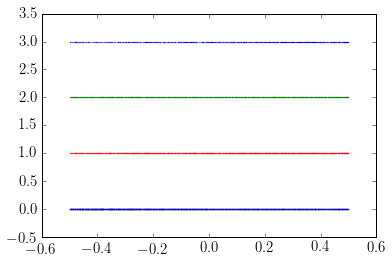

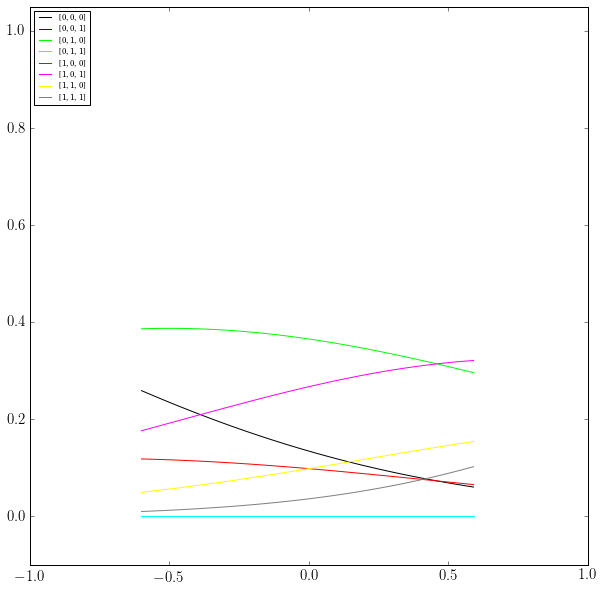

In [199]:
m = 5000
l = 3
Xm = (np.random.rand(m)-0.5)
Ym = np.zeros((m, l))

def PModel(x, y):
    f1 = Sigma(x)
    if y[0] == 0:
        f1 = 1 - f1
    f2 = Sigma(x - 2 * y[0] + 1)
    if y[1] == 0:
        f2 = 1 - f2
    f3 = Sigma(x + 12 * y[0] - 2 * y[1] - 11)
    if y[2] == 0:
        f3 = 1 - f3
    return(f1 * f2 * f3)

for i in range(Xm.shape[0]):
    # randomness for each object
    u = np.random.rand()
    for v in getB(l):
        tp = PModel(Xm[i], v)
        if tp >= u:
            Ym[i] = v
            break
        else:
            u -= tp
Y1 = Ym[:, 0]
Y2 = Ym[:, 1]
Y3 = Ym[:, 2]

#Y1=np.random.rand(m)<=Sigma(Xm)
#Y2=np.random.rand(m)<=Sigma(-Xm-2*Y1+0.5)
#Y3=np.random.rand(m)<=Sigma(Xm+12*Y1-2*Y2-11)
#Y2=Sigma(-Xm-2*Y1+0.5)>0.5
#Y3=Sigma(Xm+12*Y1-2*Y2-11)>0.5
#Ym=np.array([Y1,Y2,Y3]).T

plt.scatter(Xm, Y1, color='red', s=0.01)
plt.scatter(Xm, Y2 * 2, color='green', s=0.01)
plt.scatter(Xm, Y3 * 3, color='blue', s=0.01)
plt.show()

Xshow = np.arange(-0.6, 0.6, 0.01)
plt.figure(figsize=(10, 10))
plt.xlim([-1, 1])
plt.ylim([-0.1, 1.05])
for v in getB(l):
    c = v
    if c == [1, 1, 1]:
        c = [0.5, 0.5, 0.5]
    plt.plot(Xshow, PModel(Xshow, v), color=c, label=str(v))
plt.legend(loc=2,prop={'size':8})
plt.show()

Xmr=np.array([Xm]).T

Class 1 AUC 0.59 +- 0.02
Class 2 AUC 0.53 +- 0.03
Class 3 AUC 0.59 +- 0.02
SUBSET 0.86820 0.0
==


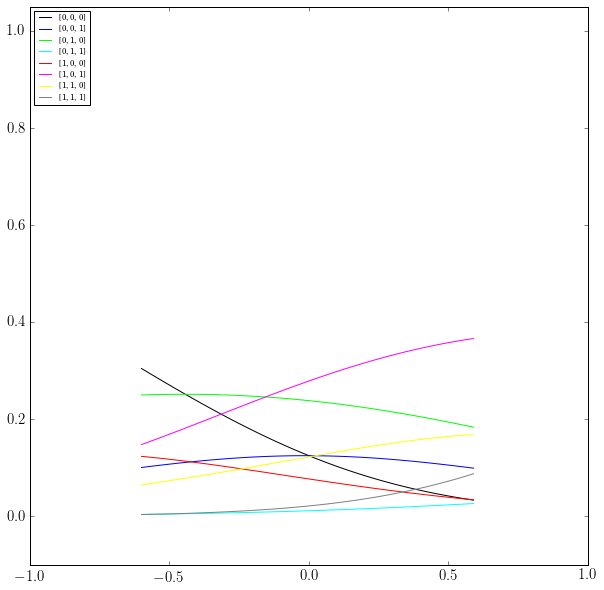

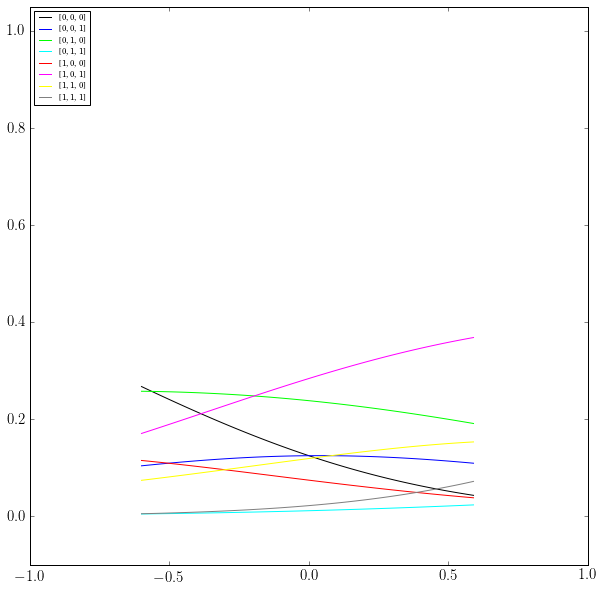

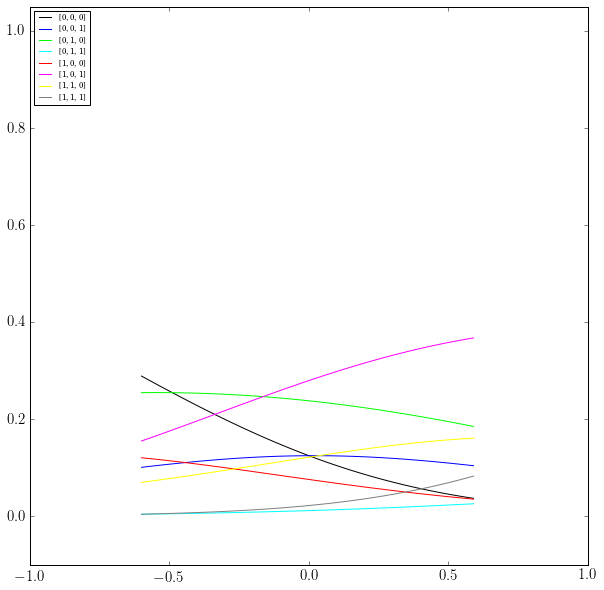

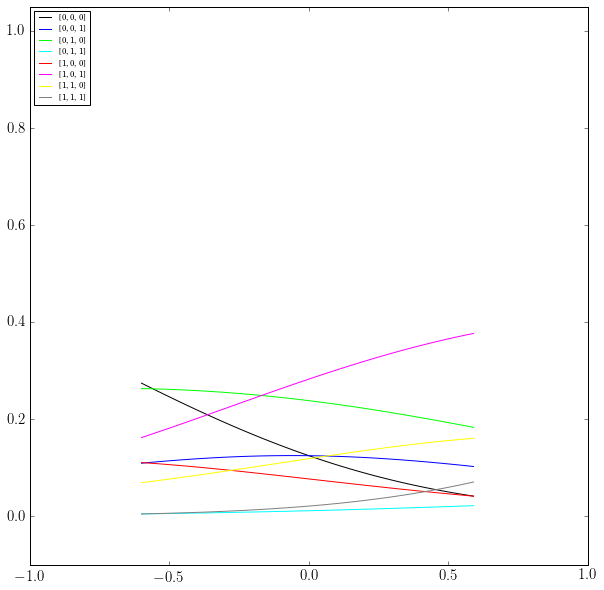

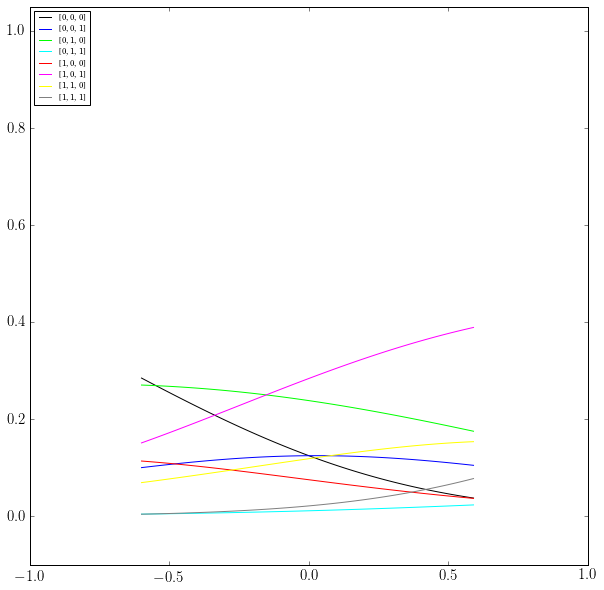

Class 1 AUC 0.59 +- 0.02
Class 2 AUC 0.53 +- 0.03
Class 3 AUC 0.59 +- 0.02
SUBSET 0.68880 0.0
==


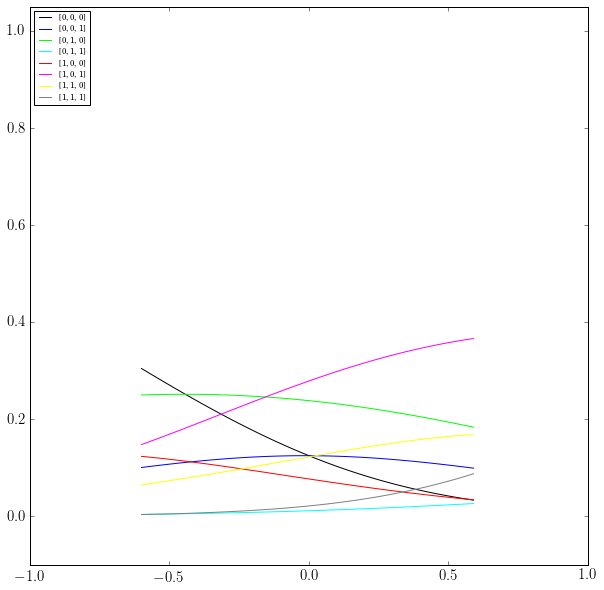

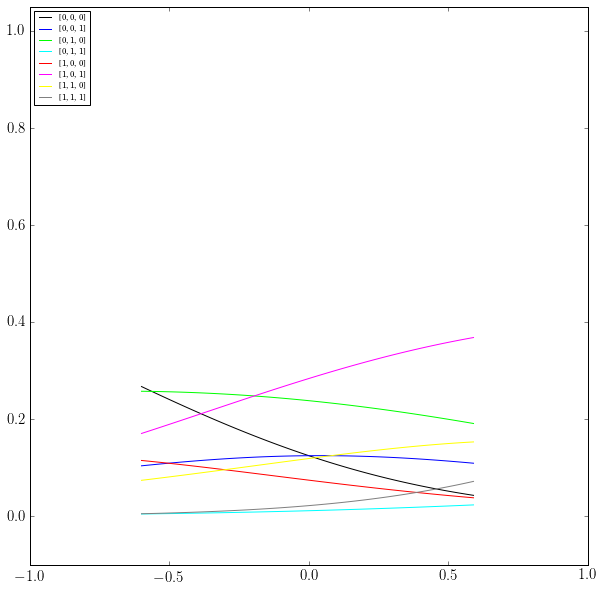

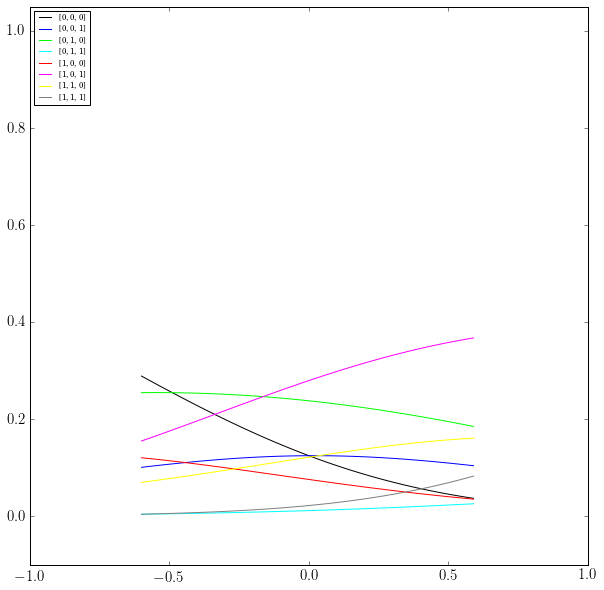

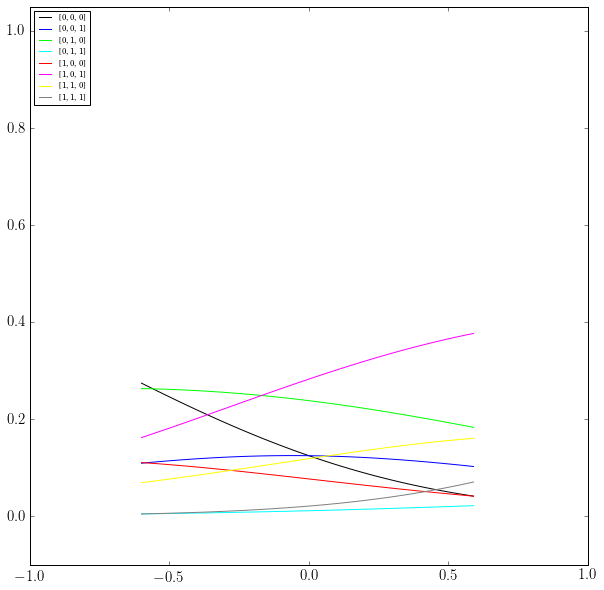

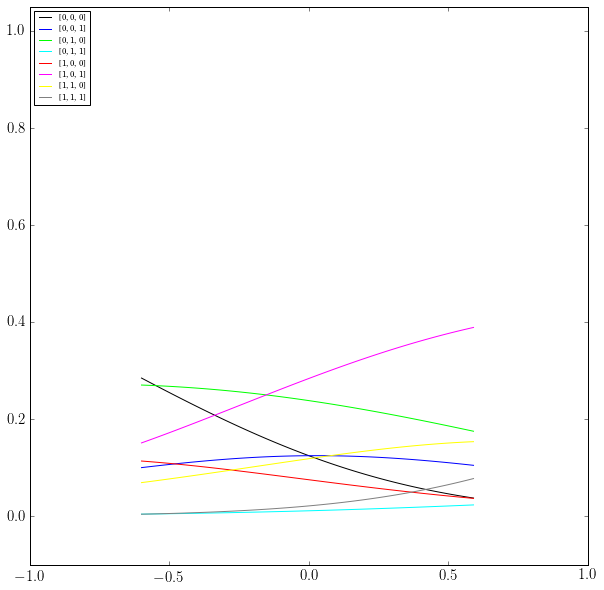

Class 1 AUC 0.59 +- 0.02
Class 2 AUC 0.49 +- 0.02
Class 3 AUC 0.59 +- 0.02
SUBSET 0.68880 0.0


In [200]:
BRShow(Xmr, Ym, 5)
print("==")
PCCShow(Xmr, Ym, 5, thr = 0.3)
print("==")
PCCShow(Xmr, Ym, 5, do_new = True, thr = 0.7)

In [ ]:
test = PCC()
test.initialize(Ym.shape[1], Xmr, Ym, 999)
for i in range(3):
    test.fitOne(i)
    test.adjustOne(i, 0.2)

In [ ]:
m=0.3
print test.probabilityClassesNew([m])
print test.probabilityClasses([m])

In [ ]:
v=[0,1,1]

In [ ]:
v[0:2]

In [19]:
y = np.array([[1, 1, 0], [1, 0, 0], [1, 1, 1], [1, 0, 0]])

In [22]:
len(np.where(np.all(y, axis = 1)==False)[0])

3

In [116]:
Ym

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  0.

In [134]:
np.array([1,2])*np.array([3,4])

array([3, 8])